<a id='top'></a>

# Wyscout Data Engineering
##### Notebook to engineered previously parsed Event data from [Wyscout](https://wyscout.com/).

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 26/01/2021<br>
Notebook last updated: 12/02/2021

![title](../../img/wyscout_logo.png)

---

## <a id='import_libraries'>Introduction</a>
This notebook parses pubicly available [Wyscout](https://wyscout.com/) football match data for the Big 5 European leagues for the 17/18 season, using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../img/edd_webster/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Wyscout%20Data%20Engineering.ipynb).

___

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Competitions](#section3.2)<br>
      3.    [Events](#section3.3)<br>
      4.    [Matches](#section3.4)<br>
      5.    [Players](#section3.5)<br>
      6.    [Teams](#section3.6)<br>
4.    [Data Engineering](#section4)<br>
      1.    [Join Datasets](#section4.1)<br>
      5.    [Export DataFrame](#section4.5)<br>
5.    [Exploratory Data Analysis (EDA)](#section5)<br>
      1.    [...](#section5.1)<br>
      2.    [...](#section5.2)<br>
      3.    [...](#section5.3)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

---

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing; and
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation.

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
%load_ext autoreload
%autoreload 2

# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Working with JSON
import json
from pandas.io.json import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Arc
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# Downloading data sources
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
from tqdm import tqdm    # Progress Bar

# Display in Jupyter
from IPython.display import Image, Video, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6
NumPy: 1.18.0
pandas: 1.2.0
matplotlib: 3.3.2
Seaborn: 0.11.1


### Defined Variables

In [3]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [4]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..',)
data_dir = os.path.join(base_dir, 'data')
data_dir_wyscout = os.path.join(base_dir, 'data', 'wyscout')
scripts_dir = os.path.join(base_dir, 'scripts')
scripts_dir_wyscout = os.path.join(base_dir, 'scripts', 'wyscout')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
fig_dir_wyscout = os.path.join(base_dir, 'img', 'fig', 'wyscout')
video_dir = os.path.join(base_dir, 'video')

### Notebook Settings

In [5]:
# Display all DataFrame columns
pd.set_option('display.max_columns', None)

---

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook explores how to parse pubicly available [Wyscout](https://wyscout.com/) JSON data of football matches for the Big 5 European leagues for the 17/18 season using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

The resulting five engineered DataFrames for each of the Big 5 European league are exported to CSV files. This data can be further analysed in Python, joined to other datasets, or explored using Tableau, PowerBI, Microsoft Excel.

**Notebook Conventions**:<br>
*    Variables that refer a `DataFrame` object are prefixed with `df_`.
*    Variables that refer to a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.

**References**:<br>
This notebook uses Wyscout data, made publicly available in the following paper by Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. **[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions](https://www.nature.com/articles/s41597-019-0247-7)**. In *Scientific Data 6*, no. 1 (2019): 1-15.

---

## <a id='#section3'>3. Data Sources</a>

### <a id='#section3.1'>3.1. Introduction</a>

#### <a id='#section3.1.1'>3.1.1. About Wyscout</a>
[Wyscout](https://wyscout.com/) is an Italian company that supports football scouting, match analysis and transfer dynamics. The company was founded in Genoa, Italy in 2004 and provides video analysis tools and digital databases regarding performances and matches for coaches, teams and players dealing with football business.

![title](../../img/wyscout_logo.png)

The purpose is to allow them have a detailed sight of a large number of athletes about individual performances, patterns of play and tactical strategy.

This notebook explores a complete dataset of event data for the Big 5 European leagues during the 17/18 season.

#### <a id='#section3.1.2'>3.1.2. About the Wyscout publicly available data</a>
A detailed description of the data can be found in the following paper:
- Pappalardo, L., Cintia, P., Rossi, A. et al. **A public data set of spatio-temporal match events in soccer competitions**. Scientific Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

It is from this paper import the *matches*, *events*, *players*, *playerank*, *referees*, *coaches*, and *competition* data sets from the <a href="https://doi.org/10.6084/m9.figshare.c.4415000.v5">figshare repository</a>. Data are stored in the `JSON` format. 

The complete data set contains:
- 1,941 matches
- 3,251,294 events
- 4,299 players.

The datasets we will be using are:
- competitions;
- events;
- matches;
- players; and
- teams

The data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and cleaned in the Data Engineering section [Section 4](#section4).

### <a id='#section3.2'>3.2. Read in Data</a>
The following cells read in the engineered CSV data prepared in the [Data Parsing](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/2_data_parsing/Wyscout%20Parsing.ipynb) noteook.

####  <a id='#section3.3.1.'>3.3.1. Data Dictionary</a>

The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

####  <a id='#section3.3.2.'>3.3.2. Read in CSV as pandas DataFrame</a>

In [6]:
# Read in preparsed Wyscout Events DataFrame
df_wyscout_raw = pd.read_csv(os.path.join(data_dir_wyscout, 'raw', 'csv', 'combined', 'wyscout_big5_combined.csv'))

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (18,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


###  <a id='#section3.3.'>3.3. Initial Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [7]:
# Display the first 5 rows of the raw DataFrame, df_wyscout_raw
df_wyscout_raw.head()

,eventId,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags,status,roundId,gameweek,seasonId,dateutc,winner,venue,wyId_x,label,date,referees,duration,competitionId,wyId_y,area_name,weight,firstName,middleName,lastName,birthDate,height,wyId_x.1,foot,shortName,passportArea_name,role_name,birthArea_name,name,wyId_y.1
0,8,Simple pass,26010,"[{'y': 48, 'x': 50}, {'y': 50, 'x': 47}]",1694390,Pass,4418,1H,1.255990,85.0,88178642,[{'id': 1801}],Played,4165470,1,9291,2016-06-10 19:00:00,4418,Stade de France,1694390,"France - Romania, 2 - 1",2016-06-10 21:00:00-02:00,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Regular,102,102,NaN,88,Olivier,NaN,Giroud,1986-09-30,192,26010,left,O. Giroud,France,Forward,France,France,4418
1,8,Simple pass,3682,"[{'y': 50, 'x': 47}, {'y': 48, 'x': 41}]",1694390,Pass,4418,1H,2.351908,85.0,88178643,[{'id': 1801}],Played,4165470,1,9291,2016-06-10 19:00:00,4418,Stade de France,1694390,"France - Romania, 2 - 1",2016-06-10 21:00:00-02:00,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Regular,102,102,NaN,71,Antoine,NaN,Griezmann,1991-03-21,175,3682,left,A. Griezmann,France,Forward,France,France,4418
2,8,Simple pass,31528,"[{'y': 48, 'x': 41}, {'y': 35, 'x': 32}]",1694390,Pass,4418,1H,3.241028,85.0,88178644,[{'id': 1801}],Played,4165470,1,9291,2016-06-10 19:00:00,4418,Stade de France,1694390,"France - Romania, 2 - 1",2016-06-10 21:00:00-02:00,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Regular,102,102,NaN,68,N'Golo,NaN,Kanté,1991-03-29,168,31528,right,N. Kanté,Mali,Midfielder,France,France,4418
3,8,High pass,7855,"[{'y': 35, 'x': 32}, {'y': 6, 'x': 89}]",1694390,Pass,4418,1H,6.033681,83.0,88178645,[{'id': 1802}],Played,4165470,1,9291,2016-06-10 19:00:00,4418,Stade de France,1694390,"France - Romania, 2 - 1",2016-06-10 21:00:00-02:00,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Regular,102,102,NaN,75,Laurent,NaN,Koscielny,1985-09-10,186,7855,right,L. Koscielny,Poland,Defender,France,France,4418
4,1,Ground defending duel,25437,"[{'y': 6, 'x': 89}, {'y': 0, 'x': 85}]",1694390,Duel,4418,1H,13.143591,12.0,88178646,"[{'id': 702}, {'id': 1801}]",Played,4165470,1,9291,2016-06-10 19:00:00,4418,Stade de France,1694390,"France - Romania, 2 - 1",2016-06-10 21:00:00-02:00,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Regular,102,102,NaN,70,Blaise,NaN,Matuidi,1987-04-09,175,25437,left,B. Matuidi,Angola,Midfielder,France,France,4418


In [8]:
# Display the last 5 rows of the raw DataFrame, df_wyscout_raw
df_wyscout_raw.tail()

,eventId,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags,status,roundId,gameweek,seasonId,dateutc,winner,venue,wyId_x,label,date,referees,duration,competitionId,wyId_y,area_name,weight,firstName,middleName,lastName,birthDate,height,wyId_x.1,foot,shortName,passportArea_name,role_name,birthArea_name,name,wyId_y.1
3025251,2,Foul,21234,"[{'y': 87, 'x': 24}, {'y': 82, 'x': 26}]",2576338,Foul,3185,2H,2824.741855,20.0,253567159,[],Played,4406278,38,181248,2018-05-20 13:00:00,3185,NaN,2576338,"Genoa - Torino, 1 - 2","May 20, 2018 at 3:00:00 PM GMT+2","[{'refereeId': 393614, 'role': 'referee'}, {'r...",Regular,524,524,Italy,72,Andrea,NaN,Belotti,1993-12-20,181,21234,right,A. Belotti,Italy,Forward,Italy,Torino,3185
3025252,3,Free kick cross,70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32.0,253567160,"[{'id': 801}, {'id': 1801}]",Played,4406278,38,181248,2018-05-20 13:00:00,3185,NaN,2576338,"Genoa - Torino, 1 - 2","May 20, 2018 at 3:00:00 PM GMT+2","[{'refereeId': 393614, 'role': 'referee'}, {'r...",Regular,524,524,Italy,64,Iuri José,NaN,Picanço Medeiros,1994-07-10,174,70974,left,Iuri Medeiros,Portugal,Forward,Portugal,Genoa,3193
3025253,1,Ground loose ball duel,14745,"[{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]",2576338,Duel,3185,2H,2872.101142,13.0,253567161,"[{'id': 702}, {'id': 1801}]",Played,4406278,38,181248,2018-05-20 13:00:00,3185,NaN,2576338,"Genoa - Torino, 1 - 2","May 20, 2018 at 3:00:00 PM GMT+2","[{'refereeId': 393614, 'role': 'referee'}, {'r...",Regular,524,524,Italy,82,Cristian,NaN,Molinaro,1983-07-30,182,14745,left,C. Molinaro,Italy,Defender,Italy,Torino,3185
3025254,1,Ground loose ball duel,413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13.0,253567163,"[{'id': 702}, {'id': 1801}]",Played,4406278,38,181248,2018-05-20 13:00:00,3185,NaN,2576338,"Genoa - Torino, 1 - 2","May 20, 2018 at 3:00:00 PM GMT+2","[{'refereeId': 393614, 'role': 'referee'}, {'r...",Regular,524,524,Italy,83,Jawad,NaN,El Yamiq,1992-02-29,190,413041,right,J. El Yamiq,Morocco,Defender,Morocco,Genoa,3193
3025255,1,Air duel,20927,"[{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]",2576338,Duel,3185,2H,2874.049206,10.0,253567162,"[{'id': 703}, {'id': 1801}]",Played,4406278,38,181248,2018-05-20 13:00:00,3185,NaN,2576338,"Genoa - Torino, 1 - 2","May 20, 2018 at 3:00:00 PM GMT+2","[{'refereeId': 393614, 'role': 'referee'}, {'r...",Regular,524,524,Italy,84,Lorenzo,NaN,De Silvestri,1988-05-23,186,20927,right,L. De Silvestri,Italy,Defender,Italy,Torino,3185


In [9]:
# Print the shape of the raw DataFrame, ddf_wyscout_raw
print(df_wyscout_raw.shape)

(3025256, 41)


In [10]:
# Print the column names of the raw DataFrame, df_wyscout_raw
print(df_wyscout_raw.columns)

Index(['eventId', 'subEventName', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id',
       'tags', 'status', 'roundId', 'gameweek', 'seasonId', 'dateutc',
       'winner', 'venue', 'wyId_x', 'label', 'date', 'referees', 'duration',
       'competitionId', 'wyId_y', 'area_name', 'weight', 'firstName',
       'middleName', 'lastName', 'birthDate', 'height', 'wyId_x.1', 'foot',
       'shortName', 'passportArea_name', 'role_name', 'birthArea_name', 'name',
       'wyId_y.1'],
      dtype='object')


The joined dataset has forty features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [11]:
# Data types of the features of the raw DataFrame, df_wyscout_raw
df_wyscout_raw.dtypes

eventId                int64
subEventName          object
playerId               int64
positions             object
matchId                int64
eventName             object
teamId                 int64
matchPeriod           object
eventSec             float64
subEventId           float64
id                     int64
tags                  object
status                object
roundId                int64
gameweek               int64
seasonId               int64
dateutc               object
winner                 int64
venue                 object
wyId_x                 int64
label                 object
date                  object
referees              object
duration              object
competitionId          int64
wyId_y                 int64
area_name             object
weight                 int64
firstName             object
middleName           float64
lastName              object
birthDate             object
height                 int64
wyId_x.1               int64
foot          

Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [12]:
# Info for the raw DataFrame, df_wyscout_raw
df_wyscout_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025256 entries, 0 to 3025255
Data columns (total 41 columns):
 #   Column             Dtype  
---  ------             -----  
 0   eventId            int64  
 1   subEventName       object 
 2   playerId           int64  
 3   positions          object 
 4   matchId            int64  
 5   eventName          object 
 6   teamId             int64  
 7   matchPeriod        object 
 8   eventSec           float64
 9   subEventId         float64
 10  id                 int64  
 11  tags               object 
 12  status             object 
 13  roundId            int64  
 14  gameweek           int64  
 15  seasonId           int64  
 16  dateutc            object 
 17  winner             int64  
 18  venue              object 
 19  wyId_x             int64  
 20  label              object 
 21  date               object 
 22  referees           object 
 23  duration           object 
 24  competitionId      int64  
 25  wyId_y            

In [13]:
# Description of the raw DataFrame, df_wyscout_raw, showing some summary statistics for each numberical column in the DataFrame
df_wyscout_raw.describe()

,eventId,playerId,matchId,teamId,eventSec,subEventId,id,roundId,gameweek,seasonId,winner,wyId_x,competitionId,wyId_y,weight,middleName,height,wyId_x.1,wyId_y.1
count,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.017102e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,0.0,3.025256e+06,3.025256e+06,3.025256e+06
mean,5.694230e+00,8.953778e+04,2.494932e+06,3.004373e+03,1.390728e+03,6.013484e+01,2.158336e+08,4.391560e+06,1.815116e+01,1.709805e+05,2.317237e+03,2.494932e+06,4.797790e+02,4.797790e+02,7.622714e+01,NaN,1.820490e+02,8.953778e+04,3.004373e+03
std,3.141030e+00,1.169272e+05,1.591746e+05,2.925207e+03,8.347843e+02,3.257763e+01,3.023051e+07,5.686541e+04,1.126545e+01,4.054451e+04,3.021050e+03,1.591746e+05,1.845044e+02,1.845044e+02,7.149052e+00,NaN,7.032542e+00,1.169272e+05,2.925207e+03
min,1.000000e+00,1.200000e+01,1.694390e+06,6.740000e+02,0.000000e+00,1.000000e+01,8.817864e+07,4.165363e+06,0.000000e+00,9.291000e+03,0.000000e+00,1.694390e+06,2.800000e+01,2.800000e+01,0.000000e+00,NaN,0.000000e+00,1.200000e+01,6.740000e+02
25%,1.000000e+00,9.380000e+03,2.500086e+06,1.619000e+03,6.608105e+02,1.300000e+01,1.988861e+08,4.405654e+06,8.000000e+00,1.811440e+05,6.740000e+02,2.500086e+06,3.640000e+02,3.640000e+02,7.200000e+01,NaN,1.780000e+02,9.380000e+03,1.619000e+03
50%,8.000000e+00,2.562300e+04,2.516836e+06,2.460000e+03,1.374896e+03,8.300000e+01,2.191298e+08,4.405655e+06,1.800000e+01,1.811500e+05,1.633000e+03,2.516836e+06,4.260000e+02,4.260000e+02,7.600000e+01,NaN,1.820000e+02,2.562300e+04,2.460000e+03
75%,8.000000e+00,1.345420e+05,2.565827e+06,3.766000e+03,2.109554e+03,8.500000e+01,2.352463e+08,4.406122e+06,2.800000e+01,1.811890e+05,3.173000e+03,2.565827e+06,5.240000e+02,5.240000e+02,8.100000e+01,NaN,1.870000e+02,1.345420e+05,3.766000e+03
max,1.000000e+01,5.685830e+05,2.576338e+06,1.983000e+04,3.537356e+03,1.000000e+02,2.802175e+08,4.406278e+06,3.800000e+01,1.812480e+05,1.983000e+04,2.576338e+06,7.950000e+02,7.950000e+02,1.010000e+02,NaN,2.030000e+02,5.685830e+05,1.983000e+04


<AxesSubplot:>

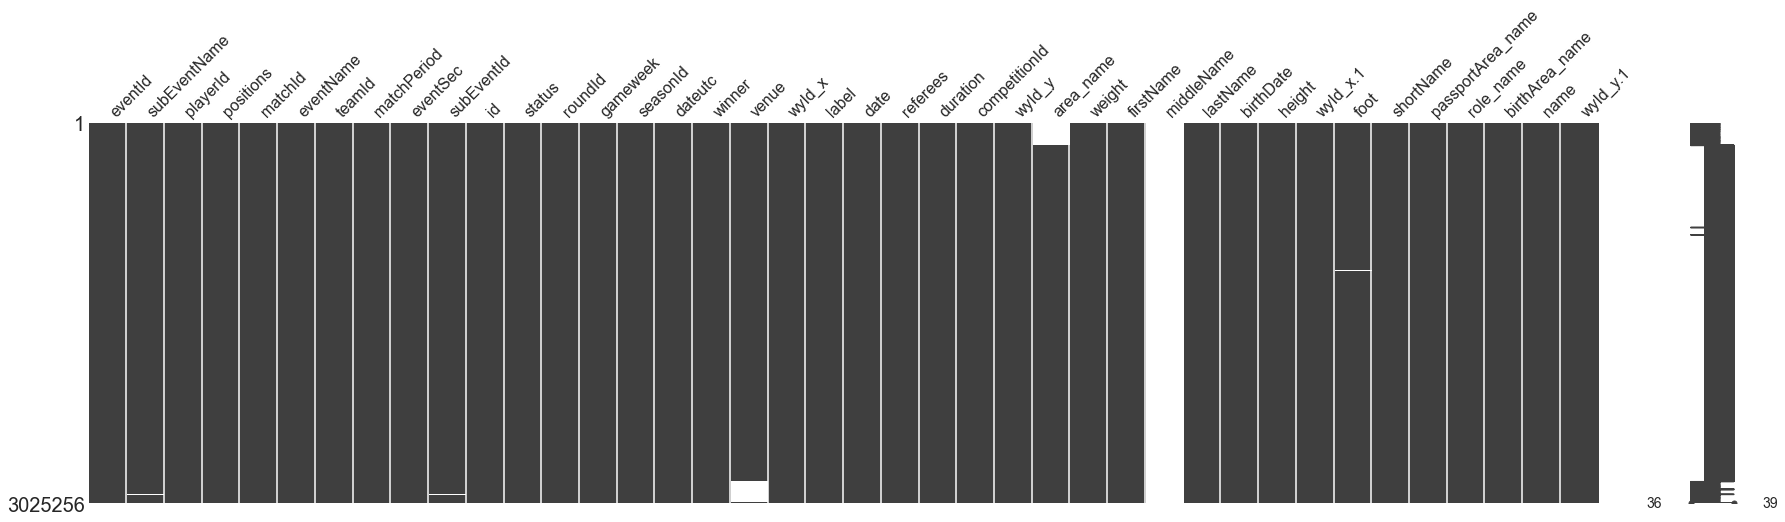

In [14]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_wyscout_raw
msno.matrix(df_wyscout_raw, figsize = (30, 7))

In [15]:
# Counts of missing values
null_value_stats = df_wyscout_raw.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

subEventName       8154
subEventId         8154
venue            166662
area_name        179899
middleName      3025256
foot                609
dtype: int64

The visualisation shows us that there are no missing values in the DataFrame.

---

## <a id='#section4'>4. Data Engineering</a>
Before any Feature Engineering or Data Visualisation, we first need to clean and wrangle the datasets to a form that meet our needs.

### <a id='#section4.1'>4.1. Assign Raw DataFrame to Engineered DataFrame</a>

In [13]:
# Assign Raw DataFrame to Engineered DataFrame
df_wyscout = df_wyscout_raw

### <a id='#section4.2'>4.2. String Cleaning</a>

##### Split `Label` column into seperate `Fixture` and `Score` columns

In [14]:
# Break down 'Label' column into constituent parts - Fixtures, Score, Date, Home Goals, Away Goals, etc.
df_wyscout['fixture'] = df_wyscout['label'].str.split(', ').str[0]
df_wyscout['score_home_away'] = df_wyscout['label'].str.split(', ').str[1]
df_wyscout['team_home'] = df_wyscout['fixture'].str.split(' - ').str[0]
df_wyscout['team_away'] = df_wyscout['fixture'].str.split(' - ').str[1]
df_wyscout['goals_home'] = df_wyscout['score_home_away'].str.split(' - ').str[0]
df_wyscout['goals_away'] = df_wyscout['score_home_away'].str.split(' - ').str[1]

##### Split `date` column into separate `date_isolated` and `time_isolated` columns

In [15]:
df_wyscout['date_isolated'] = df_wyscout['date'].str.split(' at').str[0]
df_wyscout['time_isolated'] = df_wyscout['date'].str.split(' at ').str[1]
df_wyscout['date_time_isolated'] = df_wyscout['date'].str.split(' GMT').str[0].str.replace(' at ', ' ', regex=True)

### <a id='#section4.3'>4.3. Rename Columns</a>

In [16]:
df_wyscout = df_wyscout.rename(columns={'name': 'teamName'})

### <a id='#section4.4'>4.4. Convert Data Types</a>

In [17]:
df_wyscout['date_time_timestamp'] = pd.to_datetime(df_wyscout['dateutc'])
df_wyscout['date_date'] = df_wyscout['date_time_timestamp'].dt.strftime('%d-%m-%Y')
df_wyscout['time_time'] = df_wyscout['date_time_timestamp'].dt.time

In [19]:
df_wyscout['full_fixture_date'] = df_wyscout['date_date'].astype(str) + ' ' + df_wyscout['team_home'].astype(str)  + ' ' + df_wyscout['goals_home'].astype(str) + ' ' + ' v ' + ' ' + df_wyscout['goals_away'].astype(str) + ' ' + df_wyscout['team_away'].astype(str) 

### <a id='#section4.5'>4.5. Reorder DataFrame</a>
Correctly order all the rows in the DataFrame by date, time, country, fixture, half, and time in the match. Important when looking at events and the following event e.g. is possession retains? Which player receives the pass, etc.

In [20]:
df_wyscout = df_wyscout.sort_values(['date_date', 'time_time', 'competitionId', 'full_fixture_date', 'matchPeriod', 'eventSec'], ascending=[True, True, True, True, True, True])

### <a id='#section4.6'>4.6. Create Features</a>

##### Create `competition_name` column derived from the `competitionId` column

In [21]:
#

## Define dictionary of competition names per competition ID
dict_competition_name_wyscout = {28: 'FIFA World Cup',
                                 102: 'UEFA EURO 2018',
                                 364: 'Premier League',
                                 412: 'Ligue 1',
                                 426: 'Bundesliga',
                                 524: 'Seria A',
                                 795: 'La Liga'
                                }

## Apply dictionary of competition names per competition ID
df_wyscout['competition_name'] = df_wyscout['competitionId'].map(dict_competition_name_wyscout)

##### Create `season` attribute

In [22]:
#

## Define dictionary of seasons per competition ID
dict_season_wyscout = {28: '2018',
                       102: '2016',
                       364: '17/18',
                       412: '17/18',
                       426: '17/18',
                       524: '17/18',
                       795: '17/18'
                      }

## Apply dictionary of seasons per competition ID
df_wyscout['season'] = df_wyscout['competitionId'].map(dict_season_wyscout)

##### Create `fullName` attribute 
Join together the `firstName` and `lastName` attribute to create a `fullName` attribute.

In [23]:
df_wyscout['fullName'] = df_wyscout['firstName'].astype(str) + ' ' + df_wyscout['lastName'].astype(str)

##### Create `previous_event` attribute 

In [24]:
df_wyscout['previous_event'] = df_wyscout['subEventName'].shift(1)

##### Create `followingPossession` column
'teamIdNext' = following 'teamId'

In [25]:
df_wyscout['teamIdNext'] = df_wyscout['teamId'].shift(-1)
df_wyscout['teamNameNext'] = df_wyscout['teamName'].shift(-1)
df_wyscout['fullNameNext'] = df_wyscout['fullName'].shift(-1)

##### Create `player2player` column

In [26]:
df_wyscout['player2player'] = df_wyscout['fullName'] + ' - ' + df_wyscout['fullNameNext']

##### Create `isPossessionRetained` column
When `teamId` is not followed by the same `teamId` in the following row, possession is lost. We want to creat a column that stats this.

In [27]:
df_wyscout['isPossessionRetained'] = np.where(df_wyscout['teamId'] == df_wyscout['teamIdNext'], True, False)

### <a id='#section4.7'>4.7. Drop columns</a>
As this is a large dataset with >3mil rows, we will remove every column that is not required at this stage.

In [28]:
df_wyscout = df_wyscout.drop(['wyId_x', 'wyId_y', 'wyId_x.1'], axis=1)

### <a id='#section4.8'>4.8. Aggregate Data</a>
Aggregated data used for Tableau dashboarding

#### <a id='#section4.8.1'>4.8.1. Fixture Level</a>

In [29]:
# Select columns of interest

## Define columns
cols = ['season',
        'date_time_timestamp',
        'fixture',
        'team_home',
        'team_away',
        'teamName',
        'goals_home',
        'goals_away',
        'eventName',
        'subEventName'
       ]

## Streamline DataFrame with columns of interest
df_wyscout_select = df_wyscout[cols]

## 
df_wyscout_select['Opponent'] = np.where(df_wyscout_select['team_home'] == df_wyscout_select['teamName'], df_wyscout_select['team_away'], df_wyscout_select['team_home'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
#

## Group DataFrame and Aggregate on 'eventName'
df_wyscout_fixture_grouped = (df_wyscout_select
                                  .groupby(['season', 'date_time_timestamp', 'fixture', 'teamName', 'Opponent', 'goals_home', 'goals_away', 'eventName'])
                                  .agg({'eventName': ['count']})
                             )

## Drop level
df_wyscout_fixture_grouped.columns = df_wyscout_fixture_grouped.columns.droplevel(level=0)


## Reset index
df_wyscout_fixture_grouped = df_wyscout_fixture_grouped.reset_index()

## Rename columns
df_wyscout_fixture_grouped = df_wyscout_fixture_grouped.rename(columns={'season': 'Season',
                                                                        'date_time_timestamp': 'Date',
                                                                        'fixture': 'Fixture',
                                                                        'teamName': 'Team',
                                                                        'Opponent': 'Opponent',
                                                                        'goals_home': 'Goals_Home',
                                                                        'goals_away': 'Goals_Away',
                                                                        'eventName': 'Event',
                                                                        'count': 'Team_Value'
                                                                       }
                                                              )

## Display DataFrame
df_wyscout_fixture_grouped.head()

,Season,Date,Fixture,Team,Opponent,Goals_Home,Goals_Away,Event,Team_Value
0,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Duel,220
1,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Foul,12
2,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Free Kick,58
3,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Goalkeeper leaving line,2
4,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Offside,5


In [31]:
# Select columns of interest

## Define columns
cols = ['Season',
        'Date',
        'Fixture',
        'Team',
        'Opponent',
        'Event',
        'Team_Value'
       ]

## Streamline DataFrame with columns of interest
df_wyscout_fixture_grouped_select = df_wyscout_fixture_grouped[cols]

In [32]:
# Join DataFrame to itself on 'Date', 'Fixture', 'Team'/'Opponent', and 'Event', to join Team and Opponent together
df_wyscout_fixture_grouped = pd.merge(df_wyscout_fixture_grouped, df_wyscout_fixture_grouped,  how='left', left_on=['Season', 'Date', 'Fixture', 'Opponent', 'Event'], right_on = ['Season', 'Date', 'Fixture', 'Team', 'Event'])

In [33]:
# Clean Data

## Drop columns
df_wyscout_fixture_grouped = df_wyscout_fixture_grouped.drop(columns=['Team_y', 'Opponent_y', 'Goals_Home_y', 'Goals_Away_y'])

## Rename columns
df_wyscout_fixture_grouped = df_wyscout_fixture_grouped.rename(columns={'Season_x': 'Season',
                                                                        'Team_x': 'Team',
                                                                        'Opponent_x': 'Opponent',
                                                                        'Goals_Home_x': 'Goals_Home',
                                                                        'Goals_Away_x': 'Goals_Away',
                                                                        'Team_Value_x': 'Team_Value',
                                                                        'Team_Value_y': 'Opponent_Value',
                                                                       }
                                                                  )

## Replace null values with zeros
df_wyscout_fixture_grouped['Team_Value'] = df_wyscout_fixture_grouped['Team_Value'].replace(np.nan, 0)
df_wyscout_fixture_grouped['Opponent_Value'] = df_wyscout_fixture_grouped['Opponent_Value'].replace(np.nan, 0)

## Convert Opponent_Value' from Float64 to Int64 type
df_wyscout_fixture_grouped['Opponent_Value'] = df_wyscout_fixture_grouped['Opponent_Value'].astype('Int64')

## Display DataFrame
df_wyscout_fixture_grouped.head()

,Season,Date,Fixture,Team,Opponent,Goals_Home,Goals_Away,Event,Team_Value,Opponent_Value
0,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Duel,220,205
1,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Foul,12,23
2,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Free Kick,58,47
3,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Goalkeeper leaving line,2,0
4,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Offside,5,1


In [34]:
#

##
df_fixture_gw = (df_wyscout_fixture_grouped
                     .groupby(['Date', 'Team'])
                     .agg({'Team': ['nunique']})
                )

##
df_fixture_gw.columns = df_fixture_gw.columns.droplevel(level=0)


##
df_fixture_gw = df_fixture_gw.reset_index()

##
df_fixture_gw = df_fixture_gw.rename(columns={'Date': 'Date',
                                              'nunique': 'Gameweek',
                                             }
                                    )

## Groupby. See: https://stackoverflow.com/questions/18554920/pandas-aggregate-count-distinct
df_fixture_gw = (df_fixture_gw.groupby(['Team', 'Date']).sum()
                              .groupby(level=0).cumsum().reset_index()
                )

## Display DataFrame
df_fixture_gw.head()

,Team,Date,Gameweek
0,AFC Bournemouth,2017-08-12 14:00:00,1
1,AFC Bournemouth,2017-08-19 14:00:00,2
2,AFC Bournemouth,2017-08-26 11:30:00,3
3,AFC Bournemouth,2017-09-09 14:00:00,4
4,AFC Bournemouth,2017-09-15 19:00:00,5


In [35]:
# Join DataFrame 
df_wyscout_fixture_grouped = pd.merge(df_wyscout_fixture_grouped, df_fixture_gw, how='left', left_on=['Date', 'Team'], right_on = ['Date', 'Team'])

# Display DataFrame
df_wyscout_fixture_grouped.head(50)

,Season,Date,Fixture,Team,Opponent,Goals_Home,Goals_Away,Event,Team_Value,Opponent_Value,Gameweek
0,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Duel,220,205,1
1,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Foul,12,23,1
2,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Free Kick,58,47,1
3,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Goalkeeper leaving line,2,0,1
4,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Offside,5,1,1
5,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Others on the ball,46,49,1
6,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Pass,467,170,1
7,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Save attempt,4,7,1
8,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Monaco,Toulouse,3,2,Shot,12,4,1
9,17/18,2017-08-04 18:45:00,Monaco - Toulouse,Toulouse,Monaco,3,2,Duel,205,220,1


#### <a id='#section4.8.2'>4.8.2. Team Level</a>

In [36]:
# Group DataFrame by Team

##
df_wyscout_team_grouped = (df_wyscout_fixture_grouped
                               .groupby(['Team', 'Event'])
                               .agg({'Team_Value': ['sum'],
                                     'Opponent_Value': ['sum']
                                    }
                                   )
                          )

##
df_wyscout_team_grouped.columns = df_wyscout_team_grouped.columns.droplevel(level=0)

##
df_wyscout_team_grouped = df_wyscout_team_grouped.reset_index()

## Rename columns
df_wyscout_team_grouped.columns = ['Team', 'Event', 'Team_Value', 'Opponent_Value']

## Display columns
df_wyscout_team_grouped.head()

,Team,Event,Team_Value,Opponent_Value
0,AFC Bournemouth,Duel,7977,8003
1,AFC Bournemouth,Foul,350,459
2,AFC Bournemouth,Free Kick,1818,1631
3,AFC Bournemouth,Goalkeeper leaving line,75,45
4,AFC Bournemouth,Offside,51,79


### <a id='#section4.9'>4.9. Filter Final DataFrames for 'Big 5' European Leagues Only</a>

In [37]:
lst_big5_leagues = [364, 412, 426, 524, 795]

##### Events DataFrame

In [38]:
df_wyscout_big5 = df_wyscout[df_wyscout['competitionId'].isin(lst_big5_leagues)]

##### Aggregated DataFrame at fixture level

In [62]:
df_wyscout_fixture_grouped_big5 = df_wyscout_fixture_grouped[df_wyscout_fixture_grouped['competitionId'].isin(lst_big5_leagues)]

KeyError: 'competitionId'

##### Aggregated DataFrame at team level

In [ ]:
df_wyscout_team_grouped_big5 = df_wyscout_team_grouped[df_wyscout_team_grouped['competitionId'].isin(lst_big5_leagues)]

---

## <a id='#section5'>5. Export Data</a>
Export Data ready for building the Expected Goals models in the subsequent notebooks.

##### Events DataFrames

In [40]:
# Export Events DataFrame as CSV
if not os.path.exists(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_events_all_1718.csv')):
    df_wyscout.to_csv(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_events_all_1718.csv'), index=None, header=True)
else:
    pass

In [41]:
# Export Events DataFrame as CSV
if not os.path.exists(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_events_big5_1718.csv')):
    df_wyscout_big5.to_csv(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_events_big5_1718.csv'), index=None, header=True)
else:
    pass

##### Aggregated DataFrames at fixture level

In [ ]:
# Export Aggregated DataFrame at the fixture Level as CSV
if not os.path.exists(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_aggregated_fixtures_all_1718.csv')):
    df_wyscout_fixture_grouped.to_csv(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_aggregated_fixtures_all_1718.csv'), index=None, header=True)
else:
    pass

In [ ]:
# Export Aggregated DataFrame at the fixture Level as CSV
if not os.path.exists(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_aggregated_fixtures_big5_1718.csv')):
    df_wyscout_fixture_grouped_big5.to_csv(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_aggregated_fixtures_big5_1718.csv'), index=None, header=True)
else:
    pass

##### Aggregated DataFrames at team level

In [ ]:
# Export Aggregated DataFrame at the team Level as CSV
if not os.path.exists(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_aggregated_team_all_1718.csv')):
    df_wyscout_team_grouped.to_csv(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_aggregated_team_all_1718.csv'), index=None, header=True)
else:
    pass

In [ ]:
# Export Aggregated DataFrame at the team Level as CSV
if not os.path.exists(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_aggregated_team_big5_1718.csv')):
    df_wyscout_team_grouped_big5.to_csv(os.path.join(data_dir_wyscout, 'engineered', 'combined', 'wyscout_aggregated_team_big5_1718.csv'), index=None, header=True)
else:
    pass

---

## <a id='#section6'>6. Summary</a>
This notebook parses Wyscout data using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

---

## <a id='#section7'>7. Next Steps</a>
The step is to take the dataset created in this notebook and ...

---

## <a id='#section8'>8. References</a>
*    Data Parsing notebook: https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/2_data_parsing/Wyscout%20Parsing.ipynb
*    Wyscout: https://wyscout.com/
*    Wyscout Events data manual: https://footballdata.wyscout.com/events-manual/
*    Pappalardo, Luca; Massucco, Emanuele (2019): Soccer match event dataset. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4415000.v5
*    Pappalardo, L., Cintia, P., Rossi, A. et al. **A public data set of spatio-temporal match events in soccer competitions**. Scientific Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7
*   Custom function to flatten pandas DataFrames with nested JSON column: https://stackoverflow.com/questions/39899005/how-to-flatten-a-pandas-dataframe-with-some-columns-as-json

---

## <a id='#section9'>9. Further Reading</a>

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)